## GPT Classifier
In this pipeline we will classify as relevant or not each element of the test-set

In [ ]:
import sys
from pathlib import Path
# Get parent directory (Thesis-Edvin)
sys.path.append(str(Path.cwd().parent))

In [1]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection", split="test")
test_df = test.to_pandas()

### Comparison between Eathus data and DanCip data

In [ ]:
from datasets import load_dataset

test_dan = load_dataset("DanCip/github-issues-vul-detection", split="test")
test_df_dan = test_dan.to_pandas()

In [ ]:
print("len(test_df_dan):", len(test_df_dan))
print("len(test_df):", len(test_df))

print("Dan posetive count:", len(test_df_dan[test_df_dan['label']]))
print("Eathus posetive count:", len(test_df[test_df['label']]))

## Zero-shot learning

In [2]:
# Cost only of the input
(test_df.issue_msg_n_tokens.sum() / 1000000) * 0.15

np.float64(0.50932515)

In [2]:
import os
from langchain_groq import ChatGroq  # Groq's LangChain integration
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from utils import *

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

class ReplySchema(BaseModel):
    gpt_description: str = Field(
        description="Describe the vulnerability detected, if any; otherwise, write None"
    )
    gpt_vulnerability: str = Field(
        description="Describe the general type of vulnerability detected, if any; otherwise, write None"
    )
    gpt_confidence: int = Field(
        description="An integer from 1 to 5 indicating your level of confidence  (1 = very low, 2 = low, 3 = medium, 4 = high, 5 = very high)."
    )
    gpt_is_relevant: bool = Field(
        description="Boolean that states if there is a vulnerability"
    )

'''
llm = ChatGroq(
    temperature=0.0,
    model_name="llama3-70b-8192",  # Groq's fastest Llama 3 70B endpoint
    api_key=GROQ_API_KEY     # Replace with your Groq key
)
'''

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, max_tokens=15500) # maybe set max_token to 14000

prompts_dict = load_prompts(os.getcwd() + "/../utils/prompts")

prompt = ChatPromptTemplate.from_messages(
    [("system", prompts_dict["system_setupd_detailed_desc"]), ("human", "{msg}")],
)


def parser(message: ReplySchema):
    return message.model_dump_json()


llm = llm.with_structured_output(ReplySchema)
chain = prompt | llm | parser

In [2]:
print(sys.path)

['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/edvinn/KTH/DA231X-ex/mthesis_pyenv/lib/python3.12/site-packages', '/home/edvinn/KTH/DA231X-ex/Thesis-Edvin']


In [19]:
print(prompt.messages[1])

prompt=PromptTemplate(input_variables=['msg'], input_types={}, partial_variables={}, template='{msg}') additional_kwargs={}


In [ ]:
import tiktoken
from langchain_core.messages import HumanMessage, SystemMessage

# --- Token counting function ---
def count_tokens(messages, model_name="gpt-4"):
    enc = tiktoken.encoding_for_model(model_name)
    total_tokens = 0
    for msg in messages:
        role_tokens = 4  # system/human/assistant structure adds overhead
        total_tokens += role_tokens + len(enc.encode(msg.content))
    total_tokens += 2  # additional overhead for the assistant priming
    return total_tokens

example_input = "Here's a snippet of Python code to check for vulnerabilities."
filled_prompt = prompt.format_messages(msg=example_input)
# --- Count tokens in the filled prompt ---
token_count = count_tokens(filled_prompt)
print(f"Token count for prompt: {token_count}")

Token count for prompt: 4639


In [9]:
example = chain.invoke('''This is a GitHub Issue\nrepo: ZipArchive\nowner: ZipArchive\nTitle : Unhandled edge case in _sanitizedPath #680 \n\n--- start body ---\nDescription:\n\nThere is an unhandeled edge case where we can crash the application when it tries to unzip a specially crafted zip file\n\nTechnical details:\n\nBelow is a code snippet from the _sanitizedPath function used to sanitize file paths coming from zip entries before extraction to prevent path traversal, the function prepends file:/// to the provided path, standardizes it using NSURL and then removes the prepended file:///, when provided with the following path however /.., the standardized path returned by NSURL becomes file://, which has 7 characters, the package however expects at least 8 characters (length of the prepended text), this results in crashing the application.\n\n// Add scheme \"file:///\" to support sanitation on names with a colon like \"file:a/../../../usr/bin\"\nstrPath = [@\"file:///\" stringByAppendingString:strPath];\n\n// Sanitize path traversal characters to prevent directory backtracking. Ignoring these characters mimicks the default behavior of the Unarchiving tool on macOS.\n// \"../../../../../../../../../../../tmp/test.txt\" -> \"tmp/test.txt\"\n// \"a/b/../c.txt\" -> \"a/c.txt\"\nstrPath = [NSURL URLWithString:strPath].standardizedURL.absoluteString;\n\n// Remove the \"file:///\" scheme\nstrPath = [strPath substringFromIndex:8];\nPoC:\n\nimport zipfile\n\ndef compress_file(filename):\n    with zipfile.ZipFile('payload.zip', 'w') as zipf:\n        zipf.writestr(filename, \"Test payload\")\n\nfilename = '/..'\n\ncompress_file(filename)\n--- end body ---''')

In [10]:
import json
import pandas as pd

examplej = json.loads(example)

In [11]:
from IPython.display import display, Markdown, Latex
display(Markdown(examplej['gpt_vulnerability']))

# Denial of Service (DoS) Vulnerability
## Description
A Denial of Service (DoS) vulnerability occurs when an attacker can cause a system to become unavailable to legitimate users, typically by crashing the application or exhausting resources.
## Extended Description
In this case, the application crashes when it encounters a specific input that the sanitization function does not handle properly. This can be exploited by an attacker to create a specially crafted zip file that, when processed, leads to application failure.
## Demonstrative Scenario
### Scenario
An attacker creates a zip file containing a path that triggers the unhandled edge case in the _sanitizedPath function, causing the application to crash when it attempts to extract the contents.
### Vulnerable Objective-C Code:
```objective-c
// Add scheme "file:///" to support sanitation on names with a colon like "file:a/../../../usr/bin"
strPath = [@"file:///" stringByAppendingString:strPath];

// Sanitize path traversal characters to prevent directory backtracking.
strPath = [NSURL URLWithString:strPath].standardizedURL.absoluteString;

// Remove the "file:///" scheme
strPath = [strPath substringFromIndex:8];
```
### Analysis
The vulnerability arises from the assumption that the standardized URL will always return a string of sufficient length. When the input is '/..', the resulting string is 'file://', which is only 7 characters long. The subsequent call to substringFromIndex:8 leads to an out-of-bounds error, causing the application to crash. This demonstrates a failure to validate input properly, leading to a Denial of Service condition.

In [30]:
from utils import *
from pandarallel import pandarallel
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from openai import OpenAIError, RateLimitError  # Explicitly import errors

pandarallel.initialize(progress_bar=True, nb_workers=15)

@retry(
    stop=stop_after_attempt(5),  # Retry up to 5 times
    wait=wait_exponential(multiplier=2, min=1, max=60),  # Exponential backoff
    retry=retry_if_exception_type(RateLimitError),  # Retry only on rate limit errors
)
def _gpt_classify(msg):
    if not msg or not isinstance(msg, str):  # Check for empty/invalid messages
        return None
    return chain.invoke({"msg": msg})  # Adjusted for OpenAI API format

def gpt_classify(msg):
    try:
        return _gpt_classify(msg)
    except OpenAIError as e:  # Catch all OpenAI-specific errors
        print(f"OpenAI API error: {e}")
    except Exception as e:
        print(f"General error processing message: {e}")
    return None


INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
import pickle
import os
file_path = "tmp/gpt_response_zero_cwe_df.pkl"

# Define the path to your pickle file

# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    print("Pickle file loaded successfully!")
else:
    print(f"The file at {file_path} does not exist. Setting gpt_response to 'None'")
    test_df['gpt_response'] = None



Pickle file loaded successfully!


In [1]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection-gpt-zero-results", split="test")
test_df = test.to_pandas()

README.md:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/35.7M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1778 [00:00<?, ? examples/s]

In [5]:
import json
import pandas as pd

# Step 1: Combine the normalized columns back into a dictionary
test_df['gpt_response'] = test_df.apply(
    lambda row: json.dumps({
        'gpt_description': row['gpt_description'],
        'gpt_confidence': row['gpt_confidence'],
        'gpt_is_relevant': row['gpt_is_relevant']
    }) if pd.notna(row['gpt_description']) else None,
    axis=1
)

# Step 2: Drop the individual normalized columns (optional)
test_df = test_df.drop(columns=['gpt_description', 'gpt_confidence', 'gpt_is_relevant'])

In [ ]:
len(test_df[test_df.gpt_response.isna()])

In [32]:
import pickle 
import time

retries = 0
max_retries = 10
file_path = "tmp/gpt_response_zero_cwe_df.pkl"
DELAY = 60 
#test_df['gpt_response'] = None
while not test_df[test_df.gpt_response.isna()].empty and retries < max_retries :
    # Get indices of rows needing processing
    na_indices = test_df[test_df.gpt_response.isna()].index
    
    if len(na_indices) == 0:
        break
    
    # Process ONLY those rows and assign directly to original DF
    test_df.loc[na_indices, 'gpt_response'] = \
        test_df.loc[na_indices, 'issue_msg'].parallel_apply(gpt_classify)
    
    with open(file_path, "wb") as file:  # 'wb' mode writes in binary format
        pickle.dump(test_df, file)
    retries += 1
    print(f"Retry {retries}: Processed {len(na_indices)} rows")
    time.sleep(DELAY)

General error processing message: RetryError[<Future at 0x7f3dfc49e8d0 state=finished raised RateLimitError>]
OpenAI API error: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=108, prompt_tokens=1986, total_tokens=2094, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
General error processing message: RetryError[<Future at 0x7f3dfc49eba0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7f3dfc4bfaa0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7f3dfdfee780 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7f3df751ffe0 state=finished raised RateLimitError>]
General error processing message: RetryError[<Future at 0x7f3dfc

Retry 2: Processed 14 rows


In [34]:
print(*test_df.sample(3)['gpt_response'])
display(test_df.sample(3)['gpt_response'])

{"gpt_description":"The issue describes a stack overflow occurring in the `GetCodecString` method of the `AP4_AvcSampleDescription` class. This is likely due to a recursive call that does not have a proper base case, leading to excessive memory consumption and eventually crashing the program. Such stack overflows can be exploited to cause denial of service or potentially execute arbitrary code if the overflow can be controlled. Therefore, this indicates a potential security vulnerability.","gpt_vulnerability":"# Stack Overflow\n## Description\nA stack overflow occurs when a program uses more stack memory than is allocated, typically due to excessive recursion or deep function calls without a proper exit condition.\n## Extended Description\nStack overflows can lead to crashes and can be exploited in certain contexts to execute arbitrary code or cause denial of service. They often arise from programming errors such as infinite recursion or excessive memory allocation on the stack.\n## De

1604    {"gpt_description":"The issue discusses the pr...
1764    {"gpt_description":"The issue describes a prob...
126     {"gpt_description":"The issue describes a prob...
Name: gpt_response, dtype: object

In [37]:
import json
import pandas as pd

test_df['gpt_response'] = test_df['gpt_response'].map(
    lambda x: json.loads(x) if pd.notna(x) else None
)

In [38]:
print(*test_df.sample(3)['gpt_response'])
display(type(test_df['gpt_response'][0]))

{'gpt_description': 'The issue discusses a request to embed the `espeak-ng-data` folder within the espeak C library for use in another project. This request does not indicate any security vulnerability; rather, it is a feature request related to functionality and integration. There are no indications of security risks or vulnerabilities present in this issue.', 'gpt_vulnerability': 'None', 'gpt_confidence': 5, 'gpt_is_relevant': False} {'gpt_description': 'The issue discusses simplifying the watch cache implementation in Kubernetes by removing a redundant method and replacing it with another. It focuses on code maintenance and performance optimization rather than security. There are no indications of a security vulnerability present in this issue.', 'gpt_vulnerability': 'None', 'gpt_confidence': 5, 'gpt_is_relevant': False} {'gpt_description': 'The issue discusses a potential out-of-bounds access in the processing of WAV files due to the manipulation of `wav_factor` in the `DoSample2` 

dict

In [39]:
import pandas as pd

tmp = pd.json_normalize(test_df["gpt_response"])
test_df = pd.concat([test_df.drop(columns=["gpt_response"]), tmp], axis=1)

In [43]:
display(test_df.head())

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_description,gpt_vulnerability,gpt_confidence,gpt_is_relevant
0,None,None,None,None,None,None,No_CWE,None,"[llvm, llvm-project]",I don't think we are using `std::memcmp` in `l...,...,129325,False,This is a GitHub Issue\nrepo:llvm-project\nown...,297,"[0.0001077328051906079, 0.0041412957943975925,...",4464,The issue discusses the optimization of the `s...,None,5,False
1,None,None,None,None,None,None,No_CWE,None,"[cesanta, mjs]",# s2o\r\n## Environment\r\nUbuntu 22.04.3 LTS\...,...,281,False,This is a GitHub Issue\nrepo:mjs\nowner:cesant...,1673,"[-0.01231892965734005, -0.0185470562428236, 0....",3444,The issue describes a segmentation fault (SEGV...,# Memory Corruption\n## Description\nMemory co...,4,True
2,None,None,None,None,None,None,No_CWE,None,"[xuxueli, xxl-job]",1. 提供创建、修改、查询、删除任务的openapi，带页面支持签名验签\n2. app启动...,...,3641,False,This is a GitHub Issue\nrepo:xxl-job\nowner:xu...,181,"[0.02733539044857025, -0.015366464853286743, -...",4204,The issue describes a feature request for an O...,None,5,False
3,None,None,None,None,None,None,No_CWE,None,"[gpac, gpac]","Excuse me, I want to ask how to call [session....",...,2241,False,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,391,"[-0.036246322095394135, 0.033608801662921906, ...",1513,The issue describes a user inquiry about how t...,None,5,False
4,CVE-2021-39528,2021-09-20T16:15:12.077,An issue was discovered in libredwg through v0...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,415,"[Exploit, Issue Tracking, Patch, Third Party A...","[LibreDWG, libredwg]","## System info\r\n\r\nUbuntu X64, gcc (Ubuntu ...",...,256,True,This is a GitHub Issue\nrepo:libredwg\nowner:L...,2400,"[-0.03039676696062088, 0.01844700239598751, -0...",308,The issue describes a double free vulnerabilit...,# Double Free Vulnerability\n## Description\nA...,5,True


In [45]:
from datasets import Dataset

# test
ds = Dataset.from_pandas(test_df)
ds.push_to_hub("Eathus/github-issues-vul-detection-gpt-zero-vul-desc-results", split="test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-zero-vul-desc-results/commit/54042ab17b90209a8d14ef22987add0dc5be3641', commit_message='Upload dataset', commit_description='', oid='54042ab17b90209a8d14ef22987add0dc5be3641', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/github-issues-vul-detection-gpt-zero-vul-desc-results', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/github-issues-vul-detection-gpt-zero-vul-desc-results'), pr_revision=None, pr_num=None)

In [2]:
test_df[
    test_df.gpt_confidence == 5
].gpt_is_relevant.sum(), test_df.gpt_is_relevant.count()

(np.int64(328), np.int64(1778))

In [3]:
from sklearn.metrics import accuracy_score, classification_report

y_test = test_df.label.values
y_pred = test_df.gpt_is_relevant.values

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.813273340832396
Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.79      0.87      1457
        True       0.49      0.90      0.63       321

    accuracy                           0.81      1778
   macro avg       0.73      0.85      0.75      1778
weighted avg       0.89      0.81      0.83      1778



## Few-shot learning

In [1]:
import sys
from pathlib import Path

# Get parent directory (Thesis-Edvin)
sys.path.append(str(Path.cwd().parent))

In [2]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection-max", split="train")
test_df = test.to_pandas()

In [3]:
# Cost only of the input
(test_df.issue_msg_n_tokens.sum() / 1000000) * 0.15

2.98881675

In [4]:
from utils import *
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


class ReplySchema(BaseModel):
    gpt_description: str = Field(
        description="Describe the vulnerability detected, if any; otherwise, write None"
    )
    gpt_vulnerability: str = Field(
        description="Describe the general type of vulnerability detected, if any; otherwise, write None"
    )
    gpt_confidence: int = Field(
        description="An integer from 1 to 5 indicating your level of confidence  (1 = very low, 2 = low, 3 = medium, 4 = high, 5 = very high)."
    )
    gpt_is_relevant: bool = Field(
        description="boolean that states if there is a vulnerability"
    )


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0, api_key=OPENAI_API_KEY_KTH )

prompts_dict = load_prompts(os.getcwd() + "/../utils/prompts")

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", prompts_dict["system_setupd_detailed_desc"]),
        (
            "human",
            """
                aac\nIssue date:\n\n--- start body ---\nHi, developers of Bento4:\r\nIn the test of the binary mp42aac instrumented with ASAN. There are some inputs causing heap-buffer-overflow. Here is the ASAN mode output:\r\n\r\n=================================================================\r\n==4695==ERROR: AddressSanitizer: heap-buffer-overflow on address 0x6190000027a0 at pc 0x7ffff6ef6964 bp 0x7fffffffdea0 sp 0x7fffffffd648\r\nWRITE of size 4294967288 at 0x6190000027a0 thread T0\r\n    #0 0x7ffff6ef6963 in __asan_memcpy (\\/usr\\/lib\\/x86_64-linux-gnu\\/libasan.so.2+0x8c963)\r\n    #1 0x409ed4 in AP4_MemoryByteStream::WritePartial(void const*, unsigned int, unsigned int&) \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4ByteStream.cpp:785\r\n    #2 0x40d9e3 in AP4_ByteStream::Write(void const*, unsigned int) \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4ByteStream.cpp:77\r\n    #3 0x4eb601 in AP4_Atom::Write(AP4_ByteStream&) \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4Atom.cpp:229\r\n    #4 0x4eb601 in AP4_Atom::Clone() \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4Atom.cpp:316\r\n    #5 0x446d7a in AP4_SampleDescription::AP4_SampleDescription(AP4_SampleDescription::Type, unsigned int, AP4_AtomParent*) \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4SampleDescription.cpp:138\r\n    #6 0x461a8f in AP4_GenericAudioSampleDescription::AP4_GenericAudioSampleDescription(unsigned int, unsigned int, unsigned short, unsigned short, AP4_AtomParent*) \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4SampleDescription.h:259\r\n    #7 0x461a8f in AP4_AudioSampleEntry::ToSampleDescription() \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4SampleEntry.cpp:630\r\n    #8 0x48ca03 in AP4_StsdAtom::GetSampleDescription(unsigned int) \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4StsdAtom.cpp:181\r\n    #9 0x4040b6 in main \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Apps\\/Mp42Aac\\/Mp42Aac.cpp:268\r\n    #10 0x7ffff61bb83f in __libc_start_main (\\/lib\\/x86_64-linux-gnu\\/libc.so.6+0x2083f)\r\n    #11 0x408338 in _start (\\/home\\/ferry\\/dp\\/Bento4\\/mp42aac+0x408338)\r\n\r\n0x6190000027a0 is located 0 bytes to the right of 1056-byte region [0x619000002380,0x6190000027a0)\r\nallocated by thread T0 here:\r\n    #0 0x7ffff6f03712 in operator new[](unsigned long) (\\/usr\\/lib\\/x86_64-linux-gnu\\/libasan.so.2+0x99712)\r\n    #1 0x414c8e in AP4_DataBuffer::ReallocateBuffer(unsigned int) \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4DataBuffer.cpp:210\r\n    #2 0x414c8e in AP4_DataBuffer::SetBufferSize(unsigned int) \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4DataBuffer.cpp:136\r\n    #3 0x414c8e in AP4_DataBuffer::Reserve(unsigned int) \\/home\\/ferry\\/dp\\/Bento4\\/Source\\/C++\\/Core\\/Ap4DataBuffer.cpp:107\r\n\r\nSUMMARY: AddressSanitizer: heap-buffer-overflow ??:0 __asan_memcpy\r\nShadow bytes around the buggy address:\r\n  0x0c327fff84a0: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00\r\n  0x0c327fff84b0: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00\r\n  0x0c327fff84c0: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00\r\n  0x0c327fff84d0: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00\r\n  0x0c327fff84e0: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00\r\n=>0x0c327fff84f0: 00 00 00 00[fa]fa fa fa fa fa fa fa fa fa fa fa\r\n  0x0c327fff8500: fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa\r\n  0x0c327fff8510: fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa\r\n  0x0c327fff8520: fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa\r\n  0x0c327fff8530: fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa\r\n  0x0c327fff8540: fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa fa\r\nShadow byte legend (one shadow byte represents 8 application bytes):\r\n  Addressable:           00\r\n  Partially addressable: 01 02 03 04 05 06 07 \r\n  Heap left redzone:       fa\r\n  Heap right redzone:      fb\r\n  Freed heap region:       fd\r\n  Stack left redzone:      f1\r\n  Stack mid redzone:       f2\r\n  Stack right redzone:     f3\r\n  Stack partial redzone:   f4\r\n  Stack after return:      f5\r\n  Stack use after scope:   f8\r\n  Global redzone:          f9\r\n  Global init order:       f6\r\n  Poisoned by user:        f7\r\n  Container overflow:      fc\r\n  Array cookie:            ac\r\n  Intra object redzone:    bb\r\n  ASan internal:           fe\r\n==4695==ABORTING\r\n\r\n### Crash input\r\nhttps:\\/\\/github.com\\/17ssDP\\/fuzzer_crashes\\/blob\\/main\\/Bento4\\/input2\r\n\r\n### Validation steps\r\n```\r\ngit clone https:\\/\\/github.com\\/axiomatic-systems\\/Bento4\r\ncd Bento4\\/\r\nmkdir check_build && cd check_build\r\ncmake ..\\/ -DCMAKE_C_COMPILER=clang  -DCMAKE_CXX_COMPILER=clang++ -DCMAKE_C_FLAGS=\"-fsanitize=address\" -DCMAKE_CXX_FLAGS=\"-fsanitize=address\" -DCMAKE_BUILD_TYPE=Release\r\nmake -j \r\n.\\/mp42aac input2 \\/dev\\/null\r\n```\r\n### Environment\r\nUbuntu 16.04\r\nClang 10.0.1\r\ngcc 5.5\r\n\r\n\n--- end body ---\n
            """,
        ),
        (
            "ai",
            """
            \"gpt_description\": \"Buffer overflow vulnerability in function AP4_MemoryByteStream::WritePartial in mp42aac in Bento4 v1.6.0-639, allows attackers to cause a denial of service via a crafted file.\", \"gpt_vulnerability\": \"# Buffer Copy without Checking Size of Input (\'Classic Buffer Overflow\')\n\n## Description\nThe product copies an input buffer to an output buffer without verifying that the size of the input buffer is less than the size of the output buffer, leading to a buffer overflow.\n\n## Extended Description\nA buffer overflow condition exists when a product attempts to put more data in a buffer than it can hold, or when it attempts to put data in a memory area outside of the boundaries of a buffer. The simplest type of error, and the most common cause of buffer overflows, is the "classic" case in which the product copies the buffer without restricting how much is copied. Other variants exist, but the existence of a classic overflow strongly suggests that the programmer is not considering even the most basic of security protections.\n\n## Demonstrative Scenario\n\n### Scenario\nThe following code asks the user to enter their last name and then attempts to store the value entered in the last_name array.\n\n### Vulnerable C Code\n```c\nchar last_name[20];\n\tprintf ("Enter your last name: ");\n\tscanf ("%s", last_name);\n```\n\n### Analysis\n\nThe problem with the code above is that it does not restrict or limit the size of the name entered by the user. If the user enters "Very_very_long_last_name" which is 24 characters long, then a buffer overflow will occur since the array can only hold 20 characters total.\", \"gpt_confidence\": 5, \"gpt_is_relevant\": true
            """,
        ),
        (
            "human",
            """
            This is a GitHub Issue\nrepo:MonetDB\nowner:MonetDB\nTitle : MonetDB server 11.46.0 crashes at list_append #7383\n\nIssue date:\n\n--- start body ---\nDescribe the bug\nMonetDB server 11.46.0 crashes at list_append after executing SQL statements through mclient.\n\nTo Reproduce\n\ncreate table t1(c1 int auto_increment primary key NOT NULL);\ncreate trigger i1 after insert on t1 for each row insert into t1 values(NULL);\ninsert into t1 values(NULL);\nExpected behavior\nThis crash is strange. From the backtrace as follows, we can know that the crash is caused by infinite recursion.\n\nHowever, if we change the first statement into create table t1(c1 int);, the MonetDB will return the message Query too complex: running out of stack space when executing the third stmt. So, MonetDB handles out of stack space, but it does not work with some special table definitions?\n\nWhat's more, the definition of the table contains the NOT NULL constraint, which should fail the third stmt. If we remove the create trigger statement, MonetDB will return the message INSERT INTO: NOT NULL constraint violated for column t1.c1 when executing the insert stmt. But with the create trigger stmt, it crashes instead.\n\nAnyway, I think the expected behavior is to return the error message Query too complex: running out of stack space or INSERT INTO: NOT NULL constraint violated for column t1.c1, instead of crashing straightly.\n\nBacktrace\n\n#0 0x7f0c3760dbda (list_append+0x1a)\n#1 0x7f0c376669c6 (rel_insert+0x196)\n#2 0x7f0c3766abb3 (rel_updates+0x1ce3)\n#3 0x7f0c376c6c11 (sequential_block+0x121)\n#4 0x7f0c376c52dc (rel_psm+0x131c)\n#5 0x7f0c37653091 (rel_semantic+0x91)\n#6 0x7f0c37652e6a (rel_parse+0x19a)\n#7 0x7f0c37563102 (sql_insert_triggers+0x232)\n#8 0x7f0c3755bb5e (rel2bin_insert+0x148e)\n#9 0x7f0c37554539 (subrel_bin+0xd69)\n#10 0x7f0c3755f218 (exp_bin+0x29e8)\n#11 0x7f0c37558567 (subrel_bin+0x4d97)\n#12 0x7f0c37563162 (sql_insert_triggers+0x292)\n#13 0x7f0c3755bb5e (rel2bin_insert+0x148e)\n#14 0x7f0c37554539 (subrel_bin+0xd69)\n#15 0x7f0c3755f218 (exp_bin+0x29e8)\n#16 0x7f0c37558567 (subrel_bin+0x4d97)\n#17 0x7f0c37563162 (sql_insert_triggers+0x292)\n...\n#7407 0x7f0c37563162 (sql_insert_triggers+0x292)\n#7408 0x7f0c3755bb5e (rel2bin_insert+0x148e)\n#7409 0x7f0c37554539 (subrel_bin+0xd69)\n#7410 0x7f0c3755373b (output_rel_bin+0x6b)\n#7411 0x7f0c3757f9d9 (backend_dumpstmt+0x199)\n#7412 0x7f0c3754a367 (SQLparser+0x5d7)\n#7413 0x7f0c3754987b (SQLengine_+0x59b)\n#7414 0x7f0c37548343 (SQLengine+0x23)\n#7415 0x7f0c378d76cf (runScenario+0x4f)\n#7416 0x7f0c378d816c (MSscheduleClient+0x68c)\n#7417 0x7f0c3797fc2b (doChallenge+0xfb)\n#7418 0x7f0c37ffeba0 (THRstarter+0x100)\n#7419 0x7f0c3806ecc4 (thread_starter+0x34)\n#7420 0x7f0c373e3609 (start_thread+0xd9)\n#7421 0x7f0c37308133 (clone+0x43)\nSoftware versions\n\nMonetDB server version: 11.46.0 (hg id: 63a42c2) (pulled from the master branch)\nMonetDB client version: mclient, version 11.48.0 (hg id: 63a42c2)\nOS and version: ubuntu 20.04\nSelf-installed and compiled. The command line of compilation: CC=clang-12 CXX=clang++-12 cmake /root/monetdb_master -DCMAKE_BUILD_TYPE=RelWithDebInfo\nIssue labeling\nbug\n\nAdditional context\nThe MonetDB here runs in-memory database. The command line of starting MonetDB server is mserver5 --in-memory.\n--- end body ---\n
            """,
        ),
        (
            "ai",
            """
            \"gpt_description\": \"An issue in the list_append component of MonetDB Server v11.45.17 and v11.46.0 allows attackers to cause a Denial of Service (DoS) via crafted SQL statements.\", \"gpt_vulnerability\": \"# Allocation of Resources Without Limits or Throttling\n\n## Description\nThe product allocates a reusable resource or group of resources on behalf of an actor without imposing any restrictions on the size or number of resources that can be allocated, in violation of the intended security policy for that actor.\n\n## Extended Description\n\n\nCode frequently has to work with limited resources, so programmers must be careful to ensure that resources are not consumed too quickly, or too easily. Without use of quotas, resource limits, or other protection mechanisms, it can be easy for an attacker to consume many resources by rapidly making many requests, or causing larger resources to be used than is needed. When too many resources are allocated, or if a single resource is too large, then it can prevent the code from working correctly, possibly leading to a denial of service.\n\n## Demonstrative Scenario\n\n### Scenario\nThis code allocates a socket and forks each time it receives a new connection.\n\n### Vulnerable C Code\n```c\nsock=socket(AF_INET, SOCK_STREAM, 0);\n\twhile (1) {{\n\t\tnewsock=accept(sock, ...);\n\t\tprintf("A connection has been accepted\\n");\n\t\tpid = fork();\n\t}}\n```\n\n### Analysis\n\nThe program does not track how many connections have been made, and it does not limit the number of connections. Because forking is a relatively expensive operation, an attacker would be able to cause the system to run out of CPU, processes, or memory by making a large number of connections. Alternatively, an attacker could consume all available connections, preventing others from accessing the system remotely.\", \"gpt_confidence\": 5, \"gpt_is_relevant\": true
            """,
        ),
        (
            "human",
            """
            This is a GitHub Issue repo:libredwg owner:LibreDWG Title : Segmentation fault in acds_private Issue date: --- start body --- [2.zip](https://github.com/LibreDWG/libredwg/files/11244857/2.zip) ``` (gdb) (gdb) r -v9 /home/user/out/default/crashes/2* The program being debugged has been started already. Start it from the beginning? (y or n) y Starting program: /home/user/libredwg/dwgread -v9 /home/user/out/default/crashes/2* Reading DWG file /home/user/out/default/crashes/2.dwg Program received signal SIGSEGV, Segmentation fault. 0xb6c8eb26 in acds_private (dat=0xbfffe330, dwg=0xbfffe578) at src/acds.spec:215 215 SUB_FIELD_RL (schidx.props[rcount2],index, 0); (gdb) ``` --- end body ---
            """,
        ),
        (
            "ai",
            """
            \"gpt_description\": \"\", \"gpt_vulnerability\": \"\", \"gpt_confidence\": 2,\n    \"gpt_is_relevant\": false
            """,
        ),
        ("human", "{msg}"),
    ]
)


def parser(message: ReplySchema):
    return message.model_dump_json()


llm = llm.with_structured_output(ReplySchema)
chain = prompt | llm | parser

In [5]:
example = chain.invoke('''This is a GitHub Issue\nrepo: ZipArchive\nowner: ZipArchive\nTitle : Unhandled edge case in _sanitizedPath #680 \n\n--- start body ---\nDescription:\n\nThere is an unhandeled edge case where we can crash the application when it tries to unzip a specially crafted zip file\n\nTechnical details:\n\nBelow is a code snippet from the _sanitizedPath function used to sanitize file paths coming from zip entries before extraction to prevent path traversal, the function prepends file:/// to the provided path, standardizes it using NSURL and then removes the prepended file:///, when provided with the following path however /.., the standardized path returned by NSURL becomes file://, which has 7 characters, the package however expects at least 8 characters (length of the prepended text), this results in crashing the application.\n\n// Add scheme \"file:///\" to support sanitation on names with a colon like \"file:a/../../../usr/bin\"\nstrPath = [@\"file:///\" stringByAppendingString:strPath];\n\n// Sanitize path traversal characters to prevent directory backtracking. Ignoring these characters mimicks the default behavior of the Unarchiving tool on macOS.\n// \"../../../../../../../../../../../tmp/test.txt\" -> \"tmp/test.txt\"\n// \"a/b/../c.txt\" -> \"a/c.txt\"\nstrPath = [NSURL URLWithString:strPath].standardizedURL.absoluteString;\n\n// Remove the \"file:///\" scheme\nstrPath = [strPath substringFromIndex:8];\nPoC:\n\nimport zipfile\n\ndef compress_file(filename):\n    with zipfile.ZipFile('payload.zip', 'w') as zipf:\n        zipf.writestr(filename, \"Test payload\")\n\nfilename = '/..'\n\ncompress_file(filename)\n--- end body ---''')

In [6]:
import json
import pandas as pd

examplej = json.loads(example)

In [7]:
from IPython.display import display, Markdown, Latex
display(Markdown(examplej['gpt_vulnerability']))

# Improper Input Validation

## Summary
The product does not properly validate input data, leading to unexpected behavior or crashes when handling edge cases. 

## Extended Description
Improper input validation occurs when a program does not adequately check the data it receives before processing it. This can lead to various issues, including crashes, security vulnerabilities, or unexpected behavior. In this case, the application fails to handle a specific input that results in a path length mismatch, causing a segmentation fault. Such vulnerabilities can be exploited by attackers to crash the application or potentially execute arbitrary code, depending on the context. 

## Demonstrative Example

### Intro
The following code attempts to read a file path and sanitize it for further processing. However, it does not account for certain edge cases that can lead to crashes.

### Vulnerable Code
```swift
// Add scheme "file:///" to support sanitation on names with a colon like "file:a/../../../usr/bin"
strPath = [@"file:///" stringByAppendingString:strPath];

// Sanitize path traversal characters to prevent directory backtracking.
strPath = [NSURL URLWithString:strPath].standardizedURL.absoluteString;

// Remove the "file:///" scheme
strPath = [strPath substringFromIndex:8];
```

### Analysis
The code does not check the length of the resulting standardized URL before attempting to remove the "file:///" scheme. If the input path is such that the standardized URL is shorter than expected, this will lead to an out-of-bounds access when trying to create a substring, resulting in a crash. This demonstrates a classic case of improper input validation, where the application fails to handle unexpected or malformed input gracefully.

In [5]:
example_input = "Here's a snippet of Python code to check for vulnerabilities."
filled_prompt = prompt.format_messages(msg=example_input)
# --- Count tokens in the filled prompt ---
token_count = count_tokens(filled_prompt, 'gpt-4o-mini')
print(f"Token count for prompt: {token_count}")

TypeError: expected string or buffer

In [7]:
from utils import *
from pandarallel import pandarallel
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from openai import OpenAIError, RateLimitError  # Explicitly import errors

pandarallel.initialize(progress_bar=True, nb_workers=15)

@retry(
    stop=stop_after_attempt(5),  # Retry up to 5 times
    wait=wait_exponential(multiplier=2, min=1, max=60),  # Exponential backoff
    retry=retry_if_exception_type(RateLimitError),  # Retry only on rate limit errors
)
def _gpt_classify(msg):
    if not msg or not isinstance(msg, str):  # Check for empty/invalid messages
        return None
    return chain.invoke({"msg": msg})  # Adjusted for OpenAI API format

def gpt_classify(msg):
    try:
        return _gpt_classify(msg)
    except OpenAIError as e:  # Catch all OpenAI-specific errors
        print(f"OpenAI API error: {e}")
    except Exception as e:
        print(f"General error processing message: {e}")
    return None


INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
import pickle
import os
file_path = "tmp/gpt_response_few_cwe_train_df.pkl"

# Define the path to your pickle file

# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, 'rb') as file:
        test_df = pickle.load(file)
    print("Pickle file loaded successfully!")
else:
    print(f"The file at {file_path} does not exist. Setting gpt_response to 'None'")
    test_df['gpt_response'] = None



Pickle file loaded successfully!


In [28]:
from datasets import load_dataset

test = load_dataset("Eathus/github-issues-vul-detection-gpt-few-results", split="test")
test_df = test.to_pandas()

README.md:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/35.3M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1778 [00:00<?, ? examples/s]

In [29]:
import json
import pandas as pd

# Step 1: Combine the normalized columns back into a dictionary
test_df['gpt_response'] = test_df.apply(
    lambda row: json.dumps({
        'gpt_description': row['gpt_description'],
        'gpt_confidence': row['gpt_confidence'],
        'gpt_is_relevant': row['gpt_is_relevant']
    }) if pd.notna(row['gpt_description']) else None,
    axis=1
)

# Step 2: Drop the individual normalized columns (optional)
test_df = test_df.drop(columns=['gpt_description', 'gpt_confidence', 'gpt_is_relevant'])

In [17]:
len(test_df[test_df.gpt_response.isna()])

AttributeError: 'DataFrame' object has no attribute 'gpt_response'

In [9]:
test_df['gpt_response'] = None

In [9]:
import pickle 
import time

retries = 0
max_retries = 10
file_path = "tmp/gpt_response_few_cwe_train_df.pkl"
DELAY = 60 
#test_df['gpt_response'] = None
while not test_df[test_df.gpt_response.isna()].empty and retries < max_retries :
    # Get indices of rows needing processing
    na_indices = test_df[test_df.gpt_response.isna()].index
    
    if len(na_indices) == 0:
        break
    
    # Process ONLY those rows and assign directly to original DF
    test_df.loc[na_indices, 'gpt_response'] = \
        test_df.loc[na_indices, 'issue_msg'].parallel_apply(gpt_classify)
    
    with open(file_path, "wb") as file:  # 'wb' mode writes in binary format
        pickle.dump(test_df, file)
    retries += 1
    print(f"Retry {retries}: Processed {len(na_indices)} rows")
    time.sleep(DELAY)

In [11]:
test_df.sample(3)

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_updated_at,issue_html_url,issue_github_id,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_response
6030,CVE-2022-34000,2022-06-19T20:15:08.243,libjxl 0.6.1 has an assertion failure in LowMe...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Exploit...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,617,"[Exploit, Issue Tracking, Patch, Third Party A...","[libjxl, libjxl]",## desc\r\nThere is a assert failure in libjxl...,...,2022-09-26T08:10:29Z,https://github.com/libjxl/libjxl/issues/1477,1261520060,1477,True,This is a GitHub Issue\nrepo:libjxl\nowner:lib...,2379,"[-0.00391628872603178, 0.018415294587612152, -...",2506,"{""gpt_description"":""The issue describes an ass..."
9421,None,None,None,None,None,None,No_CWE,None,"[strukturag, libde265]",When I run enc265 binary with the main sample ...,...,2024-02-28T08:16:06Z,https://github.com/strukturag/libde265/issues/449,2158366957,449,False,This is a GitHub Issue\nrepo:libde265\nowner:s...,776,"[-0.007609690073877573, 0.04152611643075943, -...",6595,"{""gpt_description"":""The issue describes a cras..."
14,CVE-2021-40574,2022-01-13T19:15:08.317,The binary MP4Box in Gpac 1.0.1 has a double-f...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': ['Patch',...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,415,"[Exploit, Issue Tracking, Third Party Advisory]","[gpac, gpac]",- [x] I looked for a similar issue and couldn'...,...,2021-08-30T15:33:45Z,https://github.com/gpac/gpac/issues/1897,980128523,1897,True,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,2637,"[-0.019911469891667366, 0.03988103196024895, -...",1930,"{""gpt_description"":""The issue describes a buff..."


In [10]:
len(test_df[~test_df.gpt_response.isna()])

12643

In [12]:
import json
import pandas as pd

test_df['gpt_response'] = test_df['gpt_response'].map(
    lambda x: json.loads(x) if pd.notna(x) else None
)

In [13]:
import pandas as pd

tmp = pd.json_normalize(test_df["gpt_response"])
test_df = pd.concat([test_df.drop(columns=["gpt_response"]), tmp], axis=1)

In [14]:
test_df.sample(1)

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_description,gpt_vulnerability,gpt_confidence,gpt_is_relevant
4130,None,None,None,None,None,None,No_CWE,None,"[zeromq, libzmq]","Hey everyone, \r\nSorry for creating another i...",...,4766,False,This is a GitHub Issue\nrepo:libzmq\nowner:zer...,4047,"[0.007064376957714558, 0.009980733506381512, -...",16902,The issue describes a problem with message los...,None,3,False


In [15]:
from datasets import Dataset

# test
ds = Dataset.from_pandas(test_df)
ds.push_to_hub("Eathus/github-issues-vul-max-detection-gpt-few-results", split="train")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Eathus/github-issues-vul-max-detection-gpt-few-results/commit/47bb2af1611664b04d3ea5e93091d7b60d12e0f1', commit_message='Upload dataset', commit_description='', oid='47bb2af1611664b04d3ea5e93091d7b60d12e0f1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Eathus/github-issues-vul-max-detection-gpt-few-results', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Eathus/github-issues-vul-max-detection-gpt-few-results'), pr_revision=None, pr_num=None)

In [16]:
test_df[~test_df.issue_msg.isna()]

,cve_id,cve_published,cve_descriptions,cve_metrics,cve_references,cve_configurations,cve_primary_cwe,cve_tags,issue_owner_repo,issue_body,...,issue_number,label,issue_msg,issue_msg_n_tokens,issue_embedding,__index_level_0__,gpt_description,gpt_vulnerability,gpt_confidence,gpt_is_relevant
0,None,None,None,None,None,None,No_CWE,None,"[jerryscript-project, jerryscript]",https://openj9-jenkins.osuosl.org/job/Test_ope...,...,18809,False,This is a GitHub Issue\nrepo:jerryscript\nowne...,1433,"[0.03234964236617088, -0.013492912985384464, -...",5427,The issue describes a failure in a Java test c...,None,3,False
1,None,None,None,None,None,None,No_CWE,None,"[wasm3, wasm3]",### Description\r\nwasm3 does not enforce type...,...,522,False,This is a GitHub Issue\nrepo:wasm3\nowner:wasm...,1499,"[0.01817885786294937, 0.010736639611423016, -0...",13572,The issue describes a lack of type validation ...,# Type Confusion Vulnerability\n\n## Descripti...,5,True
2,None,None,None,None,None,None,No_CWE,None,"[OctopusDeploy, Issues]",### Severity\n\n_No response_\n\n### Version\n...,...,9220,False,This is a GitHub Issue\nrepo:Issues\nowner:Oct...,1186,"[-0.02857031486928463, 0.006708947010338306, -...",10122,The issue describes a problem with auto-deploy...,None,3,False
3,CVE-2018-20723,2019-01-16T16:29:00.510,A cross-site scripting (XSS) vulnerability exi...,"{'cvssMetricV2': [{'acInsufInfo': False, 'base...","[{'source': 'cve@mitre.org', 'tags': None, 'ur...",[{'nodes': [{'cpeMatch': array([{'criteria': '...,79,"[Exploit, Issue Tracking, Third Party Advisory]","[Cacti, cacti]",**Description** - \r\nThere's no escape being ...,...,2215,True,This is a GitHub Issue\nrepo:cacti\nowner:Cact...,928,"[-0.03691984713077545, -0.010362207889556885, ...",127,The issue describes a stored Cross-Site Script...,# Stored Cross-Site Scripting (XSS)\n\n## Desc...,5,True
4,None,None,None,None,None,None,No_CWE,None,"[WebAssembly, binaryen]",wasm-opt crashes when I try to optimize the Wa...,...,7053,False,This is a GitHub Issue\nrepo:binaryen\nowner:W...,876,"[-0.03437240794301033, -0.004714954644441605, ...",9450,The issue describes a crash in the wasm-opt to...,None,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12638,None,None,None,None,None,None,No_CWE,None,"[Chanzhaoyu, chatgpt-web]",现在的布局是用naiveUI的layout构成的吧，想尝试自己改变布局发现改不了，如何在最左...,...,2117,False,This is a GitHub Issue\nrepo:chatgpt-web\nowne...,195,"[0.02314615063369274, 0.014598208479583263, -0...",21556,The issue is a request for assistance in modif...,None,1,False
12639,None,None,None,None,None,None,No_CWE,None,"[gpac, gpac]",https://openj9-jenkins.osuosl.org/job/Test_ope...,...,18809,False,This is a GitHub Issue\nrepo:gpac\nowner:gpac\...,1411,"[0.02873867191374302, -0.009329655207693577, -...",4534,The issue describes a failure in a Java test c...,None,3,False
12640,None,None,None,None,None,None,No_CWE,None,"[ImageMagick, ImageMagick]",https://openj9-jenkins.osuosl.org/job/Test_ope...,...,18809,False,This is a GitHub Issue\nrepo:ImageMagick\nowne...,1425,"[0.03024117834866047, -0.017206188291311264, -...",6025,The issue describes a failure in a Java test c...,None,2,False
12641,None,None,None,None,None,None,No_CWE,None,"[Cacti, cacti]",im getting this in my log when every poller ru...,...,6047,False,This is a GitHub Issue\nrepo:cacti\nowner:Cact...,610,"[-0.028580479323863983, 0.012252683751285076, ...",9352,The issue reported indicates an uncaught error...,None,4,False


In [32]:
display(Markdown('''# Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal')

## Summary
The product does not properly validate input, allowing an attacker to access memory outside of the intended bounds, leading to a segmentation fault.

## Extended Description
Segmentation faults occur when a program attempts to read or write to a memory location that it is not allowed to access. This can happen due to various reasons, including improper handling of user input, such as array indices that exceed the allocated size. In this case, the JavaScript code provided as input causes the interpreter to attempt to access an invalid memory location, which can lead to crashes or other unintended behavior. This type of vulnerability can be exploited by attackers to cause denial of service or potentially execute arbitrary code if they can control the input.

## Demonstrative Example

### Intro
The following code attempts to access an array element based on user input without validating the index.

### Vulnerable Code
```c
int arr[10];
int index = get_user_input(); // Assume this function gets an index from user input
if (index < 0 || index >= 10) {
    // No validation, potential out-of-bounds access
}
int value = arr[index]; // This line can cause a segmentation fault if index is out of bounds
```

### Analysis
In the example above, if the user provides an index that is less than 0 or greater than or equal to 10, the program will attempt to access memory outside the bounds of the array, leading to a segmentation fault. This is similar to the issue described in the GitHub report, where the JavaScript input causes the interpreter to access invalid memory, resulting in a crash.'''))

# Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal')

## Summary
The product does not properly validate input, allowing an attacker to access memory outside of the intended bounds, leading to a segmentation fault.

## Extended Description
Segmentation faults occur when a program attempts to read or write to a memory location that it is not allowed to access. This can happen due to various reasons, including improper handling of user input, such as array indices that exceed the allocated size. In this case, the JavaScript code provided as input causes the interpreter to attempt to access an invalid memory location, which can lead to crashes or other unintended behavior. This type of vulnerability can be exploited by attackers to cause denial of service or potentially execute arbitrary code if they can control the input.

## Demonstrative Example

### Intro
The following code attempts to access an array element based on user input without validating the index.

### Vulnerable Code
```c
int arr[10];
int index = get_user_input(); // Assume this function gets an index from user input
if (index < 0 || index >= 10) {
    // No validation, potential out-of-bounds access
}
int value = arr[index]; // This line can cause a segmentation fault if index is out of bounds
```

### Analysis
In the example above, if the user provides an index that is less than 0 or greater than or equal to 10, the program will attempt to access memory outside the bounds of the array, leading to a segmentation fault. This is similar to the issue described in the GitHub report, where the JavaScript input causes the interpreter to access invalid memory, resulting in a crash.

## Results

In [ ]:
from datasets import load_dataset

test = load_dataset(
    "Eathus/github-issues-vul-detection-gpt-few-strict-vul-desc-results", split="test"
)
test_df = test.to_pandas()

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/8430 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/12643 [00:00<?, ? examples/s]

In [18]:
test_df[
    test_df.gpt_confidence == 5
].gpt_is_relevant.sum(), test_df.gpt_is_relevant.count()

(1904, 12643)

In [19]:
from sklearn.metrics import accuracy_score, classification_report

y_test = test_df.label.values
y_pred = test_df.gpt_is_relevant.values

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9318199794352606
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.93      0.96     10597
        True       0.73      0.93      0.81      2046

    accuracy                           0.93     12643
   macro avg       0.86      0.93      0.89     12643
weighted avg       0.94      0.93      0.93     12643



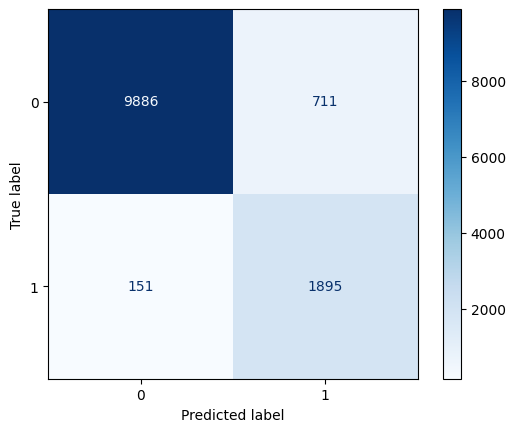

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")

In [21]:
test_df.gpt_confidence.describe()

count    12643.000000
mean         3.093807
std          1.380611
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: gpt_confidence, dtype: float64